# NEON Standardization Notebook
---
---

# Table of contents
1. [PRE-PROCESSING](#preprocess)
    1. [Load fcover data](#loadfcover)
    2. [Join fcover to species checklist table](#joinchecklist)
    3. [Join fcover to leaf retention table](#joinleafretention)
    4. [Export species-PFT tables](#exporthabits)
    5. [Clean exported species-PFT tables](#cleanhabits)
2. [STANDARDIZATION](#standardization)
    1. [Standardize PFT names](#pftnames)
    2. [Sum species fcover to PFT-level](#sumfcover)
    3. [Standardize table layout](#tablelayout)
    4. [Standardize auxiliary columns](#aux)
        1. [Basic plot information](#basics)
        2. [Geographical intersections](#geo)
        3. [Duplicate coordinates](#dupes)
3. [EXPORT](#export)

# Load required packages

In [113]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pyogrio import read_dataframe
import geopandas as gpd
import sys
import os
from urllib.request import urlretrieve
from shapely.validation import make_valid
import importlib

In [114]:
# import local functions
current_dir = os.path.abspath('..')
if current_dir not in sys.path:
    sys.path.append(current_dir)
import standardize_pft_funcs as spf
importlib.reload(spf)

<module 'standardize_pft_funcs' from '/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py'>

---
---
# 1. Pre-processing <a name="preprocess"></a>
First, we have to:
- Use the NEON API to assign coordinates to the plots
- Merge all our files into one `neon_cover_BARR_TOOL_1m2Data_YYYY-YYYY.csv
    - Every time you add a new year, run the commented out code below to make a new file
    - I would just append the new file to the old one unless there were some other updates to previous data

### A. Get coordinates for each plot

In [115]:
# ONLY NEED TO DO THIS ONCE! (Unless you just downloaded a new year of data I suppose)
# In that case, just run this for the one year and make new version of
# neon_cover_BARR_TOOL_1m2Data_2016-YYYY.csv and set YYYY to year you just added

# # Get the raw data files with no lat/lon
# base_dir = 'input_data/raw'
# file_paths = sorted(glob.glob(os.path.join(base_dir, "**", "*div_1m2Data*.csv"), recursive=True))

# dfs = []
# for file in file_paths:
#     df = read_dataframe(file)
#     dfs.append(df)

# DIR = 'input_data'
# spf.neon_plot_centroids(dfs, file_paths, DIR)

---
## 1.1. Load fcover data <a name="loadfcover"></a>

In [116]:
# throughout the script this will help keep my indices matching
def normalize_to_int_str(val):
    try:
        f = float(val)
        i = int(f)
        if f == i:
            return str(i)
    except (ValueError, TypeError):
        pass
    return str(val)

In [117]:
source = 'neon'

In [118]:
# get data
aux = pd.read_csv(f'../{source}/input_data/neon_cover_BARR_TOOL_1m2Data_2016-2023.csv', low_memory=False)
fcover = aux.copy()

# select 2021 (PAVC v1.1)
fcover['endDate'] = pd.to_datetime(fcover['endDate'], errors='coerce')
fcover = fcover[fcover['endDate'].dt.year == 2021]

In [119]:
fcover['plotVisit'] = fcover['namedLocation'] + '.' + fcover['subplotID'] + '.' + fcover['eventID']
fcover['plotVisit'] = fcover['plotVisit'].apply(normalize_to_int_str)
fcover['plotName'] = fcover['namedLocation'] + '.' + fcover['subplotID']
fcover = fcover[['plotVisit', 'scientificName', 'otherVariables', 'percentCover']]
fcover.head(3)

,plotVisit,scientificName,otherVariables,percentCover
8357,BARR_003.basePlot.div.31_1_1.BARR.1.2021,Arctophila fulva (Trin.) Rupr. ex Andersson,NaN,13.0
8358,BARR_003.basePlot.div.32_1_2.BARR.1.2021,NaN,scat,0.5
8359,BARR_003.basePlot.div.32_1_2.BARR.1.2021,Poaceae sp.,NaN,0.5


In [120]:
fcover['otherVariables'].unique()

array([nan, 'scat', 'litter', 'water', 'other', 'standingDeadHerbaceous',
       'moss', 'lichen', 'soil', 'otherNonVascular', 'standingDeadWoody',
       'rock'], dtype=object)

In [121]:
# scientific names are species, "other variables" are broad categories like "moss"
# we want to keep both
fcover['speciesName'] = fcover['scientificName'].combine_first(fcover['otherVariables'])
fcover = fcover[['plotVisit', 'speciesName', 'percentCover']]
fcover = fcover.rename(columns={'speciesName':'datasetSpeciesName'})
fcover.head(3)

,plotVisit,datasetSpeciesName,percentCover
8357,BARR_003.basePlot.div.31_1_1.BARR.1.2021,Arctophila fulva (Trin.) Rupr. ex Andersson,13.0
8358,BARR_003.basePlot.div.32_1_2.BARR.1.2021,scat,0.5
8359,BARR_003.basePlot.div.32_1_2.BARR.1.2021,Poaceae sp.,0.5


In [122]:
# get unique species names from narrowed down list
u_species_names = fcover['datasetSpeciesName'].unique()
print(len(u_species_names))
species_names_df = pd.DataFrame(u_species_names, columns=['datasetSpeciesName'])

123


---
## 1.2. Join fcover to species checklist table <a name="joinchecklist"></a>

In [123]:
# load species checklist and prep for joining
checklist_path = f'../etc/akveg_species_checklist.csv'
checklist_df = spf.checklist_df(checklist_path)
checklist_df.head(3)

,nameCode,checklistSpeciesName,nameStatus,nameAccepted,nameFamily,acceptedNameSource,nameLevel,speciesForm,speciesHabit
0,abroth,Abrothallus De Not.,accepted,Abrothallus De Not.,Abrothallaceae,CNALH,genus,lichen,lichen
1,abrpar,Abrothallus parmeliarum (Sommerf.) Arnold,accepted,Abrothallus parmeliarum (Sommerf.) Arnold,Abrothallaceae,CNALH,species,lichen,lichen
2,abrpey,Abrothallus peyritschii (Stein) Kotte,accepted,Abrothallus peyritschii (Stein) Kotte,Abrothallaceae,Dillman et al. 2012,species,lichen,lichen


In [124]:
species_names_df.head(3)

,datasetSpeciesName
0,Arctophila fulva (Trin.) Rupr. ex Andersson
1,scat
2,Poaceae sp.


In [125]:
# get first 2 words (genus-species) from checklist accepted name and data species name
checklist_df['joinKey'] = checklist_df['checklistSpeciesName'].apply(spf.get_substrings)
species_names_df['joinKey'] = species_names_df['datasetSpeciesName'].apply(spf.get_substrings)
habits = spf.join_to_checklist(unique_species=species_names_df, 
                               checklist=checklist_df, 
                               u_name='datasetSpeciesName', 
                               c_unofficial_name='checklistSpeciesName', 
                               c_official_name='nameAccepted', 
                               mapping_name='joinKey',
                               habit='speciesHabit')
habits.head(3)

49 species are missing habits.
26 species still missing habits.
15 species still missing habits.
14 species still missing habits.


,datasetSpeciesName,joinKey,speciesHabit
index,,,
0,Arctophila fulva (Trin.) Rupr. ex Andersson,Arctophila fulva,graminoid
1,scat,scat,NaN
2,Poaceae sp.,Poaceae sp.,NaN


In [126]:
species_names_df.head(3)

,datasetSpeciesName,joinKey
0,Arctophila fulva (Trin.) Rupr. ex Andersson,Arctophila fulva
1,scat,scat
2,Poaceae sp.,Poaceae sp.


In [127]:
habits = species_names_df.merge(habits, how='left', left_on='datasetSpeciesName', right_on='datasetSpeciesName', suffixes=(None, '_1'))
habits = habits[['joinKey', 'datasetSpeciesName', 'speciesHabit']]

---
## 1.3. Join fcover to leaf retention table <a name="joinleafretention"></a>

In [128]:
leaf_df = spf.leaf_retention_df('../etc/macander_leaf_retention.csv')
leaf_df.head(3)

,leafRetention,retentionSpeciesName
0,deciduous,Salix
1,deciduous,Betula nana
2,deciduous,Vaccinium uliginosum


In [129]:
# add leaf retention column
habits_wleaf = spf.add_leaf_retention(habits, leaf_df, 'leafRetention')
habits_wleaf = habits_wleaf[['datasetSpeciesName', 'joinKey', 'speciesHabit', 'leafRetention']]
habits_wleaf.head(3)

,datasetSpeciesName,joinKey,speciesHabit,leafRetention
0,Arctophila fulva (Trin.) Rupr. ex Andersson,Arctophila fulva,graminoid,
1,scat,scat,NaN,
2,Poaceae sp.,Poaceae sp.,NaN,


In [130]:
# apply function and sort by species name
habits_wleaf['speciesHabit'] = habits_wleaf['speciesHabit'].apply(spf.clean_shrub_habits)
habits_wleaf = habits_wleaf.sort_values(by='datasetSpeciesName')
list(habits_wleaf['speciesHabit'].unique())

['graminoid', 'shrub', 'forb', nan, 'spore-bearing']

---
## 1.4. Export species-PFT tables <a name="exporthabits"></a>

In [131]:
# generate 3 files and dataframe of habit types
shrubs, nonshrubs, null = spf.export_habit_files(habits_wleaf,
                                                 'temp_data', 
                                                 source, 
                                                 'speciesHabit')

In [132]:
# check to make sure the files make sense
len(habits_wleaf) == (len(null) + len(nonshrubs) + len(shrubs))

True

---
## 1.5. Clean exported species-PFT tables <a name="cleanhabits"></a>
Here, we manually assessed each file. The nonshrubs were usually correct and did not have to be adjusted. Some shrubs were missing leaf retention information, so we consulted with arctic ecologists to determine it. For unknown (null) habits, we consulted arctic ecology expert, Amy Breen, to determine the issue and correct habit. After the tables were complete, all species names had a single associated habit.
- null habits
    - assign missing habits and consult ecologist when needed
- non-shrubs
    - assign leaf habit to all trees (ctrl-f to find all trees in excel)
        - coniferous tree = evergreen
        - deciduous tree  = deciduous
    - remove leaf habit if misapplied
- shrubs
    - check current leaf habits and correct if necessary
    - fill empty leaf habits
    - choose leaf habit if both evergreen & deciduous listed
    - add Stature column (dwarf shrub or not)

---
---
# 2. Standardization <a name="standardization"></a>

---
## 2.1. Standardize PFT names <a name="pftnames"></a>
deciduous shrub, evergreen shrub, graminoid, forb, litter, non-vascular (lichen, brophyte)

In [133]:
# paths to visually assessed and cleaned habit files
all_habit_types = [f'temp_data/{source}_nonshrubs_01.csv',
                   f'temp_data/{source}_shrubs_01.csv',
                   f'temp_data/{source}_nullhabit_01.csv']

# create list of habit dataframes
habit_dfs = []
for path in all_habit_types:
    habit_df = pd.read_csv(path, index_col=0)
    habit_dfs.append(habit_df)
all_habits = pd.concat(habit_dfs)

In [134]:
# show unique habit names we're working with
all_habits['speciesHabit'].unique().tolist()

['forb',
 'graminoid',
 'spore-bearing',
 'lichen',
 'shrub',
 'unknown',
 'cyanobacteria',
 'moss',
 'fungus',
 'litter',
 'other',
 'rock',
 'salt',
 'soil',
 'dead',
 'water',
 'wood']

In [135]:
# akveg-specific habit name standardization function
def standardize_habit(habitrow, leafrow):
    
    habitrow = habitrow.to_numpy()
    leafrow = leafrow.to_numpy()
    new_row = []
    
    for habit, leaf in zip(habitrow, leafrow):
        
        habit = habit.lower() 
        # non-shrubs
        others = ['unknown', 'cyanobacteria', 'fungus', 'dead', 'wood']
        if any(other in habit for other in others):
            new_habit = 'other'
        elif 'moss' in habit or 'liverwort' in habit:
            new_habit = 'bryophyte'
        elif 'spore-bearing' in habit:
            new_habit = 'forb'
        elif 'rock' in habit or 'soil' in habit or 'salt' in habit:
            new_habit = 'bare ground'
            
        # shrubs
        elif 'shrub' in habit:
            new_habit = f'{leaf} shrub'
            
        else:
            new_habit = f'{habit}'
        new_row.append(new_habit)
    
    return new_row

In [136]:
# standardized PFT
standard_habit_col = standardize_habit(all_habits['speciesHabit'], 
                                       all_habits['leafRetention'])
all_habits['standardHabit'] = standard_habit_col
all_habits.rename(columns={'speciesHabit':'nonstandardHabit'}, inplace=True)
print(len(all_habits))
all_habits.head(3)

234


,datasetSpeciesName,joinKey,nonstandardHabit,leafRetention,standardHabit
191,Aconitum delphiniifolium DC.,Aconitum delphiniifolium,forb,NaN,forb
182,Alopecurus aequalis Sobol.,Alopecurus aequalis,graminoid,NaN,graminoid
43,Alopecurus magellanicus Lam.,Alopecurus magellanicus,graminoid,NaN,graminoid


In [137]:
all_habits['standardHabit'].unique()

array(['forb', 'graminoid', 'lichen', 'evergreen shrub',
       'deciduous shrub', 'other', 'bryophyte', 'litter', 'bare ground',
       'water'], dtype=object)

---
## 2.2. Sum species fcover to PFT-level <a name="sumfcover"></a>

In [138]:
# loop through each plot and sum fcover per pft
all_habits = all_habits[['datasetSpeciesName', 'standardHabit', 'nonstandardHabit']]
species_fcover = fcover.merge(all_habits, 
                              left_on='datasetSpeciesName', 
                              right_on='datasetSpeciesName')
species_fcover = species_fcover[['plotVisit', 'datasetSpeciesName', 'standardHabit', 
                                 'nonstandardHabit', 'percentCover']]
species_fcover.head(3)

,plotVisit,datasetSpeciesName,standardHabit,nonstandardHabit,percentCover
0,BARR_003.basePlot.div.31_1_1.BARR.1.2021,Arctophila fulva (Trin.) Rupr. ex Andersson,graminoid,graminoid,13.0
1,BARR_003.basePlot.div.32_1_2.BARR.1.2021,scat,bare ground,salt,0.5
2,BARR_003.basePlot.div.32_1_2.BARR.1.2021,Poaceae sp.,graminoid,graminoid,0.5


In [139]:
len(species_fcover['plotVisit'].unique())

280

In [140]:
# group by 'Site Code' and 'standardHabit', then sum the 'Cover'
temp = species_fcover.groupby(['plotVisit', 'standardHabit'])['percentCover'].sum().reset_index()
pft_fcover = temp.pivot(index='plotVisit', columns='standardHabit', values='percentCover')

In [141]:
# clean up
pft_fcover.columns.name = None
pft_fcover.index.name = 'plotVisit'
pft_fcover.index = pft_fcover.index.map(normalize_to_int_str)
pft_fcover.head(3)

,bare ground,bryophyte,deciduous shrub,evergreen shrub,forb,graminoid,lichen,litter,other,water
plotVisit,,,,,,,,,,
BARR_001.basePlot.div.31_1_1.BARR.1.2021,0.5,97.0,NaN,NaN,6.5,8.0,0.5,6.0,12.5,NaN
BARR_001.basePlot.div.32_1_2.BARR.1.2021,0.5,96.0,9.0,NaN,1.5,9.0,1.0,8.0,8.0,NaN
BARR_001.basePlot.div.32_1_4.BARR.1.2021,0.5,15.0,NaN,NaN,NaN,13.5,NaN,78.0,9.5,1.0


In [142]:
len(pft_fcover.index)

280

---
## 2.3. Standardize table layout <a name="tablelayout"></a>

In [143]:
# list of necessary PFTs
pfts = ['deciduous shrub', 'deciduous tree',
        'evergreen shrub', 'evergreen tree',
        'forb', 'graminoid', 'non-vascular',
        'bryophyte', 'lichen', 'litter',
        'bare ground', 'water', 'other']

In [144]:
# create non-vascular
pft_fcover['non-vascular'] = pft_fcover[['bryophyte', 'lichen']].sum(axis=1, skipna=True)

In [145]:
# create standard columns
pft_fcover = spf.add_standard_cols(pft_fcover, pfts)
pft_fcover = pft_fcover[pfts]
pft_fcover.head(3)

,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,non-vascular,bryophyte,lichen,litter,bare ground,water,other
plotVisit,,,,,,,,,,,,,
BARR_001.basePlot.div.31_1_1.BARR.1.2021,NaN,NaN,NaN,NaN,6.5,8.0,97.5,97.0,0.5,6.0,0.5,NaN,12.5
BARR_001.basePlot.div.32_1_2.BARR.1.2021,9.0,NaN,NaN,NaN,1.5,9.0,97.0,96.0,1.0,8.0,0.5,NaN,8.0
BARR_001.basePlot.div.32_1_4.BARR.1.2021,NaN,NaN,NaN,NaN,NaN,13.5,15.0,15.0,NaN,78.0,0.5,1.0,9.5


---
## 2.4. Standardize auxiliary columns <a name="aux"></a>

Plot information:
- [ ] UID
- [x] plotName
- [x] dataSource
- [x] dataSubsource
- [x] fcoverScale
- [x] surveyMethod
- [x] surveyPurpose
- [x] duplicatedCoords
- [x] duplicatedDate
- [x] surveyYear
- [x] surveyMonth
- [x] surveyDay

Geographical information:
- [x] bioclimateSubzone
- [x] adminCountry
- [x] adminUnit
- [x] fireYears
- [x] coordEpsg
- [x] georefSource
- [x] georefAccuracy
- [x] plotRadius
- [x] longitueX
- [x] latitudeY

In [146]:
# sampling methods, coverscale, data source
methods = pd.read_csv('../etc/sampling_methods.csv')

### 2.4.1. Basic plot information <a name="basics"></a>

In [147]:
def get_subsource(row):
    if 'TOOL' in row:
        subsource = 'Toolik Field Station NEON (pub 2021)'
    elif 'BARR' in row:
        subsource = 'Utqiagvik-Barrow NEON (pub 2021)'
    else:
        subsource = np.nan
    return subsource

In [148]:
new_aux = pd.DataFrame()

# date columns
aux['surveyDate'] = pd.to_datetime(aux['endDate'], format='mixed')
new_aux['surveyYear'] = aux['surveyDate'].dt.year.astype(int)
new_aux['surveyMonth'] = aux['surveyDate'].dt.month.astype(int)
new_aux['surveyDay'] = aux['surveyDate'].dt.day.astype(int)

# plot size
new_aux['plotArea'] = 1.0
new_aux['plotShape'] = 'square'

# geographical information
new_aux['latitudeY'] = aux['subplot_lat'].astype('Float32')
new_aux['longitudeX'] = aux['subplot_lon'].astype('Float32')
new_aux['georefSource'] = 'GPS'
new_aux['georefAccuracy'] = 0.25
new_aux['coordEPSG'] = 'EPSG:4326'

# main
new_aux['plotVisit'] = aux['namedLocation'] + '.' + aux['subplotID'] + '.' + aux['eventID']
new_aux['plotVisit'] = new_aux['plotVisit'].apply(normalize_to_int_str)
new_aux['plotName'] = aux['namedLocation'] + '.' + aux['subplotID']
new_aux['dataSubsource'] = aux['name'].apply(lambda x: get_subsource(x))
new_aux = new_aux.merge(methods, how='left', left_on='dataSubsource', right_on='dataSubsource')
new_aux = new_aux.groupby('plotVisit')[new_aux.columns].first()
new_aux = new_aux.set_index(new_aux['plotVisit'], drop=True)
new_aux = new_aux.drop(columns=['plotVisit'])

### 2.4.2. Geographical intersections <a name="geo"></a>

In [149]:
# set geo info
geo_paths = ['../etc/gaul1/gaul1_asap.shp',
             '../etc/fire/InterAgencyFirePerimeterHistory_All_Years_View.shp',
             '../etc/bioclim/bioclimate_la_latlon.shp']
geo_names = ['gaul1',
             'fire',
             'bioclim']
geo_cols = [['name1', 'name0', 'geometry'],
            ['FIRE_YEAR', 'geometry'],
            ['zone', 'geometry']]

In [150]:
# create geospatial information
fcover_and_aux = pft_fcover.merge(new_aux, how='left', left_index=True, right_index=True)
fcover_and_aux.index.name = 'plotVisit'
fcover_and_aux.head(3)

,deciduous shrub,deciduous tree,evergreen shrub,evergreen tree,forb,graminoid,non-vascular,bryophyte,lichen,litter,...,georefAccuracy,coordEPSG,plotName,dataSubsource,dataSource,dataSourceHtml,dataSubsourceCitation,surveyMethod,fcoverScale,surveyPurpose
plotVisit,,,,,,,,,,,,,,,,,,,,,
BARR_001.basePlot.div.31_1_1.BARR.1.2021,NaN,NaN,NaN,NaN,6.5,8.0,97.5,97.0,0.5,6.0,...,0.25,EPSG:4326,BARR_001.basePlot.div.31_1_1,Utqiagvik-Barrow NEON (pub 2021),NEON,https://data.neonscience.org/data-products/DP1...,NEON (National Ecological Observatory Network)...,simple plot,percent,"Quantify the impacts of climate change, land u..."
BARR_001.basePlot.div.32_1_2.BARR.1.2021,9.0,NaN,NaN,NaN,1.5,9.0,97.0,96.0,1.0,8.0,...,0.25,EPSG:4326,BARR_001.basePlot.div.32_1_2,Utqiagvik-Barrow NEON (pub 2021),NEON,https://data.neonscience.org/data-products/DP1...,NEON (National Ecological Observatory Network)...,simple plot,percent,"Quantify the impacts of climate change, land u..."
BARR_001.basePlot.div.32_1_4.BARR.1.2021,NaN,NaN,NaN,NaN,NaN,13.5,15.0,15.0,NaN,78.0,...,0.25,EPSG:4326,BARR_001.basePlot.div.32_1_4,Utqiagvik-Barrow NEON (pub 2021),NEON,https://data.neonscience.org/data-products/DP1...,NEON (National Ecological Observatory Network)...,simple plot,percent,"Quantify the impacts of climate change, land u..."


In [151]:
fcover_and_aux.columns

Index(['deciduous shrub', 'deciduous tree', 'evergreen shrub',
       'evergreen tree', 'forb', 'graminoid', 'non-vascular', 'bryophyte',
       'lichen', 'litter', 'bare ground', 'water', 'other', 'surveyYear',
       'surveyMonth', 'surveyDay', 'plotArea', 'plotShape', 'latitudeY',
       'longitudeX', 'georefSource', 'georefAccuracy', 'coordEPSG', 'plotName',
       'dataSubsource', 'dataSource', 'dataSourceHtml',
       'dataSubsourceCitation', 'surveyMethod', 'fcoverScale',
       'surveyPurpose'],
      dtype='object')

In [152]:
# convert to GeoDataFrame
fcover_and_aux = gpd.GeoDataFrame(
    fcover_and_aux,
    geometry=gpd.points_from_xy(fcover_and_aux['longitudeX'], fcover_and_aux['latitudeY']),
    crs='EPSG:4326'
).to_crs('EPSG:5936')

# add geospatial layers
fcover_and_aux = spf.add_geospatial_aux(
    fcover_and_aux,
    paths=geo_paths,
    orig_names=geo_cols
)

Finding spatial intersection for '['name1', 'name0', 'geometry']' in native CRS: EPSG:4326


/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:751: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged = merged.drop(columns=[col for col in merged.columns if 'geometry' in col])


Finding spatial intersection for '['FIRE_YEAR', 'geometry']' in native CRS: EPSG:4326


/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:751: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged = merged.drop(columns=[col for col in merged.columns if 'geometry' in col])


Finding spatial intersection for '['zone', 'geometry']' in native CRS: EPSG:4326


/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:751: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged = merged.drop(columns=[col for col in merged.columns if 'geometry' in col])
/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:772: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  # information; e.g., duplicate coords or dates


In [153]:
faa_li = len(fcover_and_aux.index)
faa_ui = len(fcover_and_aux.index.unique())
print(f'Number of plot visits in fcover_and_aux: {faa_li}')
print(f'Number of unique plot visits in fcover_and_aux: {faa_ui}')

Number of plot visits in fcover_and_aux: 280
Number of unique plot visits in fcover_and_aux: 280


In [154]:
# rename new columns
fcover_and_aux.rename(columns={'name1':'adminUnit',
                               'name0':'adminCountry',
                               'FIRE_YEAR':'fireYears',
                               'zone':'bioclimSubzone'}, inplace=True)

### 2.4.3. Duplicate coordinates <a name="dupes"></a>
This indicates that plots may have been revisited, they were very close and GPS accuracy was too low, or there is human error

In [155]:
fcover_and_aux = spf.find_duplicates(fcover_and_aux, ['longitudeX', 'latitudeY'], 'duplicatedCoords')
fcover_and_aux = spf.find_duplicates(fcover_and_aux, ['surveyYear', 'surveyMonth', 'surveyDay'], 'duplicatedDate')

/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:802: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  for idx, group_id in zip(df.index, group_ids):
/mnt/poseidon/remotesensing/arctic/alaska_pft_fcover_harmonization/standardize_pft_funcs.py:802: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  for idx, group_id in zip(df.index, group_ids):


---
# 3. Export <a name="export"></a>

In [156]:
# clean up
pfts = {'deciduous shrub':'deciduousShrubCover',
        'evergreen shrub':'evergreenShrubCover',
        'deciduous tree':'deciduousTreeCover',
        'evergreen tree':'evergreenTreeCover',
        'forb':'forbCover',
        'graminoid':'graminoidCover',
        'non-vascular':'nonvascularSumCover',
        'bryophyte':'bryophyteCover',
        'lichen':'lichenCover',
        'litter':'litterCover',
        'bare ground':'baregroundCover',
        'water':'waterCover',
        'other':'otherCover'}

# rename columns
fcover_and_aux.rename(columns=pfts, inplace=True)
fcover_cols = list(pfts.values())

# reproject and set cover data type
fcover_and_aux[fcover_cols] = fcover_and_aux[fcover_cols].astype(np.float32)
fcover_and_aux.index.name = 'plotVisit'

In [157]:
fcover_and_aux.columns

Index(['deciduousShrubCover', 'deciduousTreeCover', 'evergreenShrubCover',
       'evergreenTreeCover', 'forbCover', 'graminoidCover',
       'nonvascularSumCover', 'bryophyteCover', 'lichenCover', 'litterCover',
       'baregroundCover', 'waterCover', 'otherCover', 'surveyYear',
       'surveyMonth', 'surveyDay', 'plotArea', 'plotShape', 'latitudeY',
       'longitudeX', 'georefSource', 'georefAccuracy', 'coordEPSG', 'plotName',
       'dataSubsource', 'dataSource', 'dataSourceHtml',
       'dataSubsourceCitation', 'surveyMethod', 'fcoverScale', 'surveyPurpose',
       'adminUnit', 'adminCountry', 'fireYears', 'bioclimSubzone',
       'duplicatedCoords', 'duplicatedDate'],
      dtype='object')

In [158]:
# create UID mapping to plotVisit
uid_table = pd.DataFrame({'plotVisit': pft_fcover.index})
uid_table = spf.assign_uid_column(uid_table, id_col='plotVisit', uid_col='UID')

# get UIDs from Arctic AK only
path = '../etc/tundra_alaska_latlon/tundra_alaska_wgs84.shp'
ak_tundra = gpd.read_file(path)

# clip and select Arctic AK indices
fcover_and_aux = gpd.GeoDataFrame(fcover_and_aux,
                                  geometry=gpd.points_from_xy(fcover_and_aux['longitudeX'],
                                                              fcover_and_aux['latitudeY']),
                                                              crs='epsg:4326')
fcover_and_aux = fcover_and_aux.to_crs(ak_tundra.crs)
fcover_and_aux = fcover_and_aux.clip(ak_tundra)
valid_uids = fcover_and_aux.index
fcover_and_aux.columns

Index(['deciduousShrubCover', 'deciduousTreeCover', 'evergreenShrubCover',
       'evergreenTreeCover', 'forbCover', 'graminoidCover',
       'nonvascularSumCover', 'bryophyteCover', 'lichenCover', 'litterCover',
       'baregroundCover', 'waterCover', 'otherCover', 'surveyYear',
       'surveyMonth', 'surveyDay', 'plotArea', 'plotShape', 'latitudeY',
       'longitudeX', 'georefSource', 'georefAccuracy', 'coordEPSG', 'plotName',
       'dataSubsource', 'dataSource', 'dataSourceHtml',
       'dataSubsourceCitation', 'surveyMethod', 'fcoverScale', 'surveyPurpose',
       'adminUnit', 'adminCountry', 'fireYears', 'bioclimSubzone',
       'duplicatedCoords', 'duplicatedDate', 'geometry'],
      dtype='object')

<Axes: >

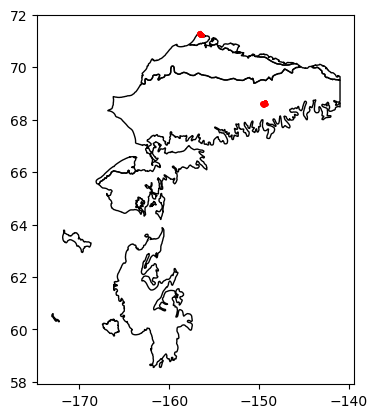

In [159]:
# plot the post-2010 alaskan tundra points
ax = ak_tundra.plot(edgecolor='black', facecolor='none')
fcover_and_aux.plot(ax=ax, color='red', markersize=3)

In [160]:
# remove geometry
fcover_and_aux['geometry'] = fcover_and_aux['geometry'].apply(lambda g: g.wkt if g is not None else None)

/tmp/ipykernel_2400700/2164478736.py:2: UserWarning: Geometry column does not contain geometry.
  fcover_and_aux['geometry'] = fcover_and_aux['geometry'].apply(lambda g: g.wkt if g is not None else None)


In [161]:
faa_li = len(fcover_and_aux.index)
faa_ui = len(fcover_and_aux.index.unique())
print(f'Number of plot visits in fcover_and_aux: {faa_li}')
print(f'Number of unique plot visits in fcover_and_aux: {faa_ui}')

Number of plot visits in fcover_and_aux: 280
Number of unique plot visits in fcover_and_aux: 280


In [162]:
# export species fcover
species_fcover_out = species_fcover.copy()
species_fcover_out = species_fcover_out[species_fcover_out['plotVisit'].isin(valid_uids)]
species_fcover_out = spf.replace_column_with_uid(species_fcover_out, uid_table, id_col='plotVisit', uid_col='UID', set_index=False, schema_key='species_fcover')
species_fcover_out = spf.format_column_dtypes(species_fcover_out, schema_key='species_fcover')
spf.export_dataframe(species_fcover_out, f'output_data/{source}_nonstandard_species_fcover.csv', schema_key='species_fcover', index=False)

In [163]:
# export pft fcover
covercols = [col for col in fcover_and_aux.columns if 'Cover' in col]
pft_fcover_out = fcover_and_aux[covercols]
pft_fcover_out = spf.replace_column_with_uid(pft_fcover_out.reset_index(), uid_table, id_col='plotVisit', uid_col='UID', set_index=True, schema_key='pft_fcover')
pft_fcover_out = spf.format_column_dtypes(pft_fcover_out, schema_key='pft_fcover')
spf.export_dataframe(pft_fcover_out, f'output_data/{source}_standard_pft_fcover.csv', schema_key='pft_fcover', index=True)

In [164]:
# export pft aux
auxcols = [col for col in fcover_and_aux.columns if 'Cover' not in col]
pft_aux = fcover_and_aux[auxcols]
pft_aux = spf.replace_column_with_uid(pft_aux.reset_index(), uid_table, id_col='plotVisit', uid_col='UID', set_index=True, schema_key='pft_aux')
pft_aux = spf.format_column_dtypes(pft_aux, schema_key='pft_aux')
spf.export_dataframe(pft_aux, f'output_data/{source}_plot_info.csv', schema_key='pft_aux', index=True)